# Unsupervised classification of normal/anomalous sounds: embedding with FaceNet + triplet loss on the machine section

To be executed on Google Colab, otherwise the computation time explodes.

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gefleury/datascientest_anomalous_sounds/blob/main/notebooks/ASD_clf_sounds_FaceNet_section.ipynb) 

In this version, the melspectrograms are loaded from the folder `Features/melspec_313_128/`. Each machine has its folder `fan/`, `valve/` etc... and each audio sample has its own (flattened) melspectrogram stored as a .npy file. For each machine type separetely, we use FaceNet to embed the melspectrograms into vectors of length 128. The embedding is done by using the triplet loss on the machine section (0, 1, 2). Then the embedding vectors are used to feed a Random Forest classifier that predicts the machine type. Sounds that are not well classified or are well classified but with a too low probability are then said to be anomalous.

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import Sequence

import os
#import cv2



## Show the gpu infos 
... and change if needed in "Execution" panel

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 19 13:56:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the spectrograms from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DATA_DCASE2022/Features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


In [ ]:
#Constants
#PATH_FEATURES_FOLDER = './Features/'
PATH_FEATURES_FOLDER = r"/content/Features/"
PATH_MELSPEC_313_128_FOLDER = PATH_FEATURES_FOLDER + 'melspec_313_128/'

## Build selection dataframe

The spectrograms are stored in the folder `Features/melspec_313_128/`. Each machinery has its folder `fan`, `valve/` etc... <br />
Each audio sample has its own mespectrogram flattened stored as a .npy file. So each file is one line of 313*128 = 40064 features.

We first build a dataframe df which gives us all the properties of the files. This will be used to select sounds according to their section, sound_type, etc ...

In [ ]:
def build_selection_dataframe(folder_path):
    list_dict_file = []    # list of dictionnaries for creating DataFrame

    for subdirectory, directory, files in os.walk(folder_path):
    
        #Get label using directory folder name
        label = subdirectory.split('/')[-1]
        
        #Loop through files
        for file in files:
            path_file = subdirectory + '/' + file
            splitted_filename = file.split('_')

            #Append dictionnary to list
            list_dict_file.append({
                'filepath' : path_file,
                'machine' : label,
                'section' : int(splitted_filename[1]),
                'domain_env' : splitted_filename[2],
                'dir' : splitted_filename[3],
                'sound_type' : splitted_filename[4],
                'id' : splitted_filename[5],
                'suffix' : '_'.join(splitted_filename[6:]).split('.npy')[0]  
            })

    return pd.DataFrame(list_dict_file)

In [ ]:
df = build_selection_dataframe(PATH_MELSPEC_313_128_FOLDER)

In [ ]:
#Encoding labels
df['sound_type'] = df['sound_type'].replace(['normal', 'anomaly'], [0, 1])


label_encoder = LabelEncoder()
df['machine_num'] = label_encoder.fit_transform(df['machine'])

dico = {}
for i in range(7):
    dico[label_encoder.inverse_transform([i])[0]] = i
df_machine = pd.DataFrame.from_dict(dico, orient = 'index', columns = ['machine_num'])

df_machine

,machine_num
ToyCar,0
ToyTrain,1
bearing,2
fan,3
gearbox,4
slider,5
valve,6


In [ ]:
df.head()

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
0,/content/Features/melspec_313_128/bearing/sect...,bearing,1,source,train,0,0540,vel_12_loc_B,2
1,/content/Features/melspec_313_128/bearing/sect...,bearing,2,target,test,0,0030,vel_6_f-n_C,2
2,/content/Features/melspec_313_128/bearing/sect...,bearing,0,source,train,0,0896,vel_22,2
3,/content/Features/melspec_313_128/bearing/sect...,bearing,2,source,train,0,0640,vel_6_f-n_B,2
4,/content/Features/melspec_313_128/bearing/sect...,bearing,2,source,train,0,0237,vel_6_f-n_B,2


In [ ]:
df['machine'].value_counts()

slider      3600
valve       3600
ToyCar      3600
ToyTrain    3600
gearbox     3600
fan         3600
bearing     3599
Name: machine, dtype: int64

## Prepare the train, valid, test datasets
We fix the machine type

In [ ]:
# Choose data
machine = 'gearbox'

# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
#test_filepaths = test_df['filepath'] 

train_labels = train_df['section']       
#test_labels = test_df['section']

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
18000,/content/Features/melspec_313_128/gearbox/sect...,gearbox,2,source,train,0,0918,id_05,4
18002,/content/Features/melspec_313_128/gearbox/sect...,gearbox,1,source,train,0,0574,wt_150,4


Group the melspectrograms per section

In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0825, 0950, 0983, 0764, 0519, 0088, 0399, 071...","[volt_2.0, volt_2.0, volt_2.0, volt_1.5, volt_...",4
1,1,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0574, 0972, 0064, 0342, 0040, 0392, 0272, 000...","[wt_150, wt_50, wt_200, wt_150, wt_150, wt_200...",4
2,2,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0918, 0210, 0045, 0388, 0805, 0066, 0092, 020...","[id_05, id_13, id_08, id_08, id_05, id_08, id_...",4


## Define the generator

In the FaceNet approach, each batch must be made of :  
- an anchor ie a random spectrogram 
- a "positive" spectrogram ie a random spectrogram with the same section type than anchor
- a "negative" spectrogram ie a random spectrogram with another section type than anchor and positive

First, define a function to load and normalize the melspectrograms (the method is a bit weird since each spectrogram is mapped to a RBG image with 3 channels instead of 1 originaly. I proceed that way to be sure the normalization is done properly and identically for each dataset).

In [ ]:
def load_spectro(filepath):
    
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Convert it to a RGB image (there are probably better ways to do it)
    plt.imsave('spectro.png', spectro_array, cmap='magma')
    img = keras.preprocessing.image.load_img('spectro.png')
    # Convert it back to an array
    img = keras.preprocessing.image.img_to_array(img)
    # Normalize
    img = img / 255
    
    #print("img shape =", img.shape)

    return img

/content/Features/melspec_313_128/slider/section_00_source_train_normal_0980_vel_900.npy


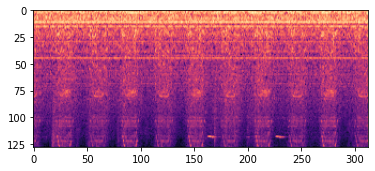

In [ ]:
# Test
my_spectro_path = df[df['machine']=='slider']['filepath'].sample(n = 1, random_state = 1).values[0]
print(my_spectro_path)

spectro_img = load_spectro(my_spectro_path)
plt.imshow(spectro_img, cmap = 'magma');

Load melspectrograms of each section into X_train, X_valid together with the section label into y_train, y_valid. X_train/X_valid is a list whose :
* First dimension corresponds to the different sections 0, 1, 2
* Second dimension corresponds to the melspectrograms of a given section



In [ ]:
from tqdm import tqdm

# Shouldn't it be included in the generator?
def load_spectros_per_section(data):
    X = []
    y = []

    for d in tqdm(data.values):
        sec, paths, mach, domains, dir, soundtypes, ids, sufs, mach_num = d
        X_section = []
        #y_section = []

        for i in range(len(paths)):
            im = load_spectro(paths[i])
            X_section.append(im)
            #y_section.append(sec)
            
        X.append(np.array(X_section))
        #y.append(np.array(y_section))
        y.append(sec)

    return X, y

X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:16<00:00,  5.41s/it]


In [ ]:
print(y_valid)

[0, 1, 2]


Define the batch generator

In [ ]:
import random

def generator(X, y, nb_sample, epochs=30, batch_size=32):
    section_range = range(0, len(X))
    while(True):
        for i in range(0, nb_sample, batch_size):
            X_batch = []
            y_batch = []
            for j in range(0, batch_size):  
                # random choice of the anchor, positive and negative (see the FaceNet paper for more evolved process)  
                section1, section2 = random.sample(section_range, 2)        
                sec1_img_1, sec1_img_2 = random.sample(range(len(X[section1])), 2)    # sec1 -> 2 spectrograms
                sec2_img_1 = random.sample(range(len(X[section2])), 1)[0]             # sec2 -> 1 spectrogram
                X_batch.extend([X[section1][sec1_img_1], X[section1][sec1_img_2], X[section2][sec2_img_1]])
                y_batch.extend([y[section1], y[section1], y[section2]])
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)
            
            # In the course : Why we do not keep the information about the label?
            # Indeed, the label is not used in the loss function 
            #yield X_batch, np.zeros(len(X_batch))     
            yield X_batch, y_batch              # My modified version to keep y but to be checked
            

batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

Show a few triplets (test)

In [ ]:
X_t, y_t = next(gen_train)
X_t.shape, y_t.shape

((96, 128, 313, 3), (96,))

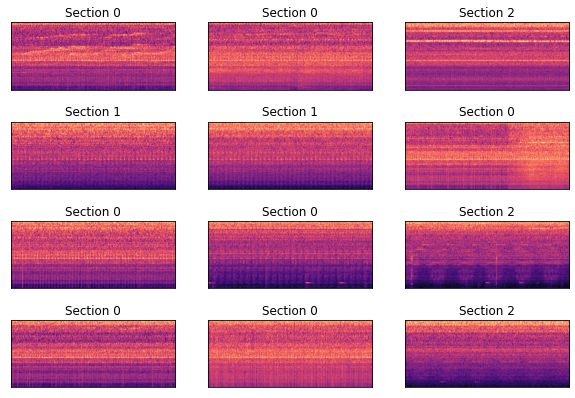

In [ ]:
plt.figure(figsize=(10,7))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3,i*3 + j +1)
        plt.imshow(X_t[i*3+j])
        plt.title("Section "+str(int(y_t[i*3+j])))
        plt.xticks([])
        plt.yticks([])


## Model definition

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=[128, 313, 3]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128))       # Embedding vector of length 128
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 313, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 156, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 156, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 78, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 39, 64)       0

Define the triplet loss function. For a triplet (anchor, positive, negative), the purpose is to get close embedding vectors of the anchor and the positive and distant embedding vectors of the anchor and the negative.

In [ ]:
alpha = 0.2

def normL2(X1, X2):
    return tf.reduce_mean(tf.square(X1-X2), axis=-1)

def loss(y_true, y_pred):
    # L2 normalisation
    y_pred = y_pred / tf.expand_dims(tf.norm(y_pred, axis=-1),-1)
    p1_id1 = y_pred[::3]
    p1_id2 = y_pred[1::3]
    p2_id1 = y_pred[2::3]                                                                  
    return tf.reduce_mean(tf.nn.relu(normL2(p1_id1, p1_id2) - normL2(p1_id1, p2_id1) + alpha)) #100*

# Another loss function
def loss_2(y_true, y_pred):
    p1_id1 = y_pred[::3]
    p1_id2 = y_pred[1::3]
    p2_id1 = y_pred[2::3]
    return tf.reduce_mean(1/2*normL2(p1_id1, p1_id2)/(1e-8+1/4* normL2(p1_id1, p2_id1) + 1/4* normL2(p1_id2, p2_id1)))

Compile and fit

In [ ]:
model.compile(loss=loss, optimizer=SGD(0.1))

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 19s 77ms/step - loss: 0.1998 - val_loss: 0.1995 - lr: 0.1000
Epoch 2/50
75/75 [==============================] - 5s 73ms/step - loss: 0.1985 - val_loss: 0.1959 - lr: 0.1000
Epoch 3/50
75/75 [==============================] - 5s 73ms/step - loss: 0.1954 - val_loss: 0.1960 - lr: 0.1000
Epoch 4/50
75/75 [==============================] - 5s 73ms/step - loss: 0.1942 - val_loss: 0.1935 - lr: 0.1000
Epoch 5/50
75/75 [==============================] - 6s 74ms/step - loss: 0.1936 - val_loss: 0.1936 - lr: 0.1000
Epoch 6/50
75/75 [==============================] - ETA: 0s - loss: 0.1932
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.
75/75 [==============================] - 5s 65ms/step - loss: 0.1932 - val_loss: 0.1939 - lr: 0.1000
Epoch 7/50
75/75 [==============================] - 5s 65ms/step - loss: 0.1919 - val_loss: 0.1918 - lr: 0.0300
Epoch 8/50
75/75 [==============================] - 5s 65ms/step - loss: 0.1

In [ ]:
#Plot training
def plot_training_diag(history, machine):
    plt.title(machine)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(np.arange(1 , len(history.history['loss']) + 1, 1),
            history.history['loss'],
            label = 'Training loss',
            color = 'blue')
    plt.plot(np.arange(1 , len(history.history['val_loss']) + 1, 1),
            history.history['val_loss'], 
            label = 'Validation loss',
            color = 'red')
    plt.legend()
    plt.show()

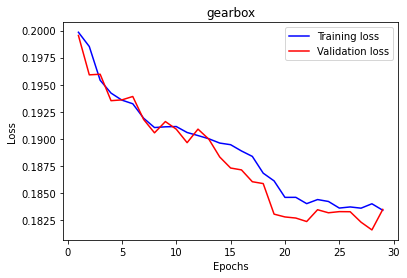

In [ ]:
plot_training_diag(training_history, machine)

## Analysis of the embedding vectors

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)

In [ ]:
X_test.shape

(600, 128, 313, 3)

Calculate the embedding vectors of the test set

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(600, 128)

### PCA analysis

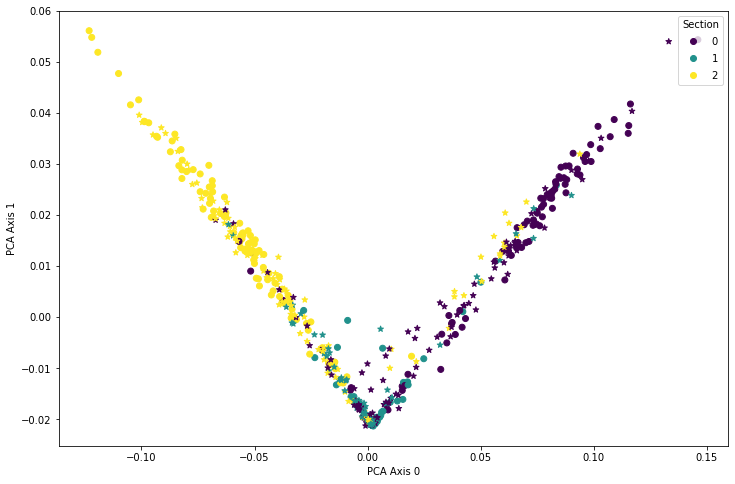

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap


pca = PCA(n_components = 2)
y_pca = pca.fit_transform(embedded_test)

#y_cat = 2*y_test_sec + y_test_soundtype
#colors = ['red', "orange", 'darkblue', 
#          'lightblue', 'grey', 'xkcd:pale grey']
#cmap = ListedColormap(colors)


fig, ax = plt.subplots(figsize = (12, 8))
# Normal sounds with circles
scatter1 = ax.scatter(y_pca[y_test_soundtype==0,0], y_pca[y_test_soundtype==0,1], c = y_test_sec[y_test_soundtype==0], marker = 'o')
# Anormal sounds with stars
scatter2 = ax.scatter(y_pca[y_test_soundtype==1,0], y_pca[y_test_soundtype==1,1], c = y_test_sec[y_test_soundtype==1], marker = '*')
ax.legend(*scatter1.legend_elements(), loc = "upper right", title = "Section")
ax.set_xlabel("PCA Axis 0")
ax.set_ylabel("PCA Axis 1");

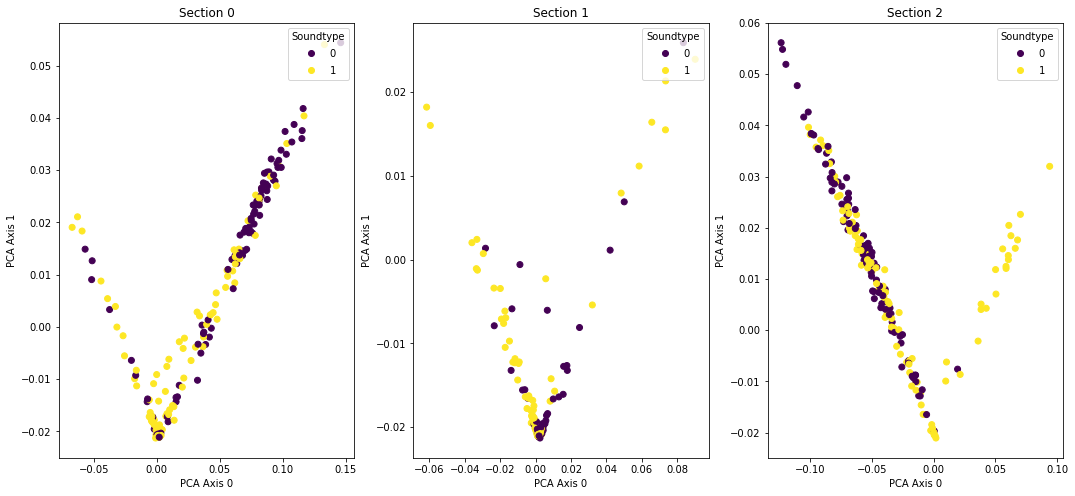

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (18, 8))
for i in range(3):
    ax = axs[i]
    scatter  = ax.scatter(y_pca[y_test_sec==i,0], y_pca[y_test_sec==i,1], c = y_test_soundtype[y_test_sec==i])
    ax.legend(*scatter.legend_elements(), loc = "upper right", title = "Soundtype")
    ax.set_xlabel("PCA Axis 0")
    ax.set_ylabel("PCA Axis 1")
    ax.set_title("Section "+str(i))

There is no clear boundary between normal and anormal sounds ....

## Supervised classification of the section using the embedding vectors
We only try with a Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(600, 2)
Train score =  0.99375


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

**Classification report on the section for the gearbox**

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        46
           1       0.73      0.71      0.72        38
           2       0.74      0.86      0.79        36

    accuracy                           0.76       120
   macro avg       0.76      0.76      0.76       120
weighted avg       0.76      0.76      0.76       120



Pred,0,1,2
True,,,
0,33,10,3
1,3,27,8
2,5,0,31


## Deduce the normal/anomalous labels
**Soundtype accuracy versus threshold**

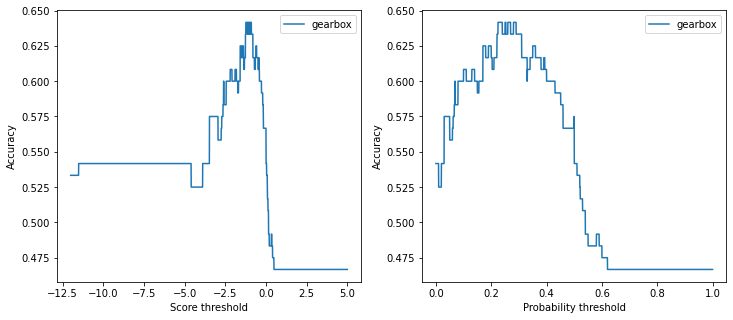

In [ ]:
# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

**AUC**

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print("Gearbox AUC = ", np.round(auc, 3))


Gearbox AUC =  0.663


This is worse than the value obtained with the method "CNNs for section classification + same analysis of prediction".

## Repeat all when data are taken only from the source domain

In [ ]:
# Choose data
machine = 'gearbox'

# We take only data from the source domain
train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
#train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
train_labels = train_df['section']       

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
1,/content/Features/melspec_313_128/gearbox/sect...,gearbox,0,source,train,0,0453,volt_3.0,4
2,/content/Features/melspec_313_128/gearbox/sect...,gearbox,1,source,train,0,0818,wt_200,4


In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0453, 0201, 0019, 0513, 0003, 0086, 0742, 045...","[volt_3.0, volt_3.0, volt_1.5, volt_3.0, volt_...",4
1,1,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0818, 0196, 0800, 0342, 0389, 0462, 0687, 083...","[wt_200, wt_50, wt_100, wt_150, wt_50, wt_100,...",4
2,2,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0085, 0528, 0147, 0941, 0216, 0564, 0205, 053...","[id_13, id_05, id_08, id_05, id_13, id_05, id_...",4


In [ ]:
X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

In [ ]:
model.compile(loss=loss, optimizer=SGD(0.1))

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 6s 75ms/step - loss: 0.1892 - val_loss: 0.1841 - lr: 0.1000
Epoch 2/50
75/75 [==============================] - 5s 72ms/step - loss: 0.1863 - val_loss: 0.1901 - lr: 0.1000
Epoch 3/50
75/75 [==============================] - 6s 74ms/step - loss: 0.1845 - val_loss: 0.1824 - lr: 0.1000
Epoch 4/50
75/75 [==============================] - 5s 65ms/step - loss: 0.1835 - val_loss: 0.1808 - lr: 0.1000
Epoch 5/50
75/75 [==============================] - 5s 65ms/step - loss: 0.1818 - val_loss: 0.1814 - lr: 0.1000
Epoch 6/50
75/75 [==============================] - ETA: 0s - loss: 0.1812
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.
75/75 [==============================] - 6s 74ms/step - loss: 0.1812 - val_loss: 0.1805 - lr: 0.1000
Epoch 7/50
75/75 [==============================] - 5s 66ms/step - loss: 0.1811 - val_loss: 0.1806 - lr: 0.0300
Epoch 8/50
75/75 [==============================] - 5s 64ms/step - loss: 0.18

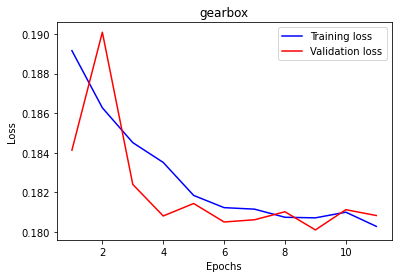

In [ ]:
#Plot training
def plot_training_diag(history, machine):
    plt.title(machine)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(np.arange(1 , len(history.history['loss']) + 1, 1),
            history.history['loss'],
            label = 'Training loss',
            color = 'blue')
    plt.plot(np.arange(1 , len(history.history['val_loss']) + 1, 1),
            history.history['val_loss'], 
            label = 'Validation loss',
            color = 'red')
    plt.legend()
    plt.show()

plot_training_diag(training_history, machine)

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(300, 128)

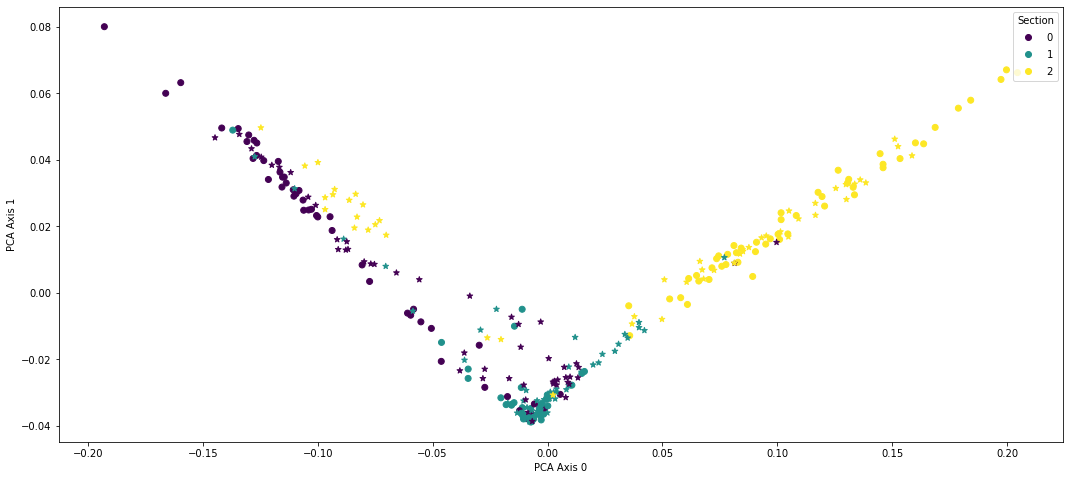

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap


pca = PCA(n_components = 2)
y_pca = pca.fit_transform(embedded_test)

#y_cat = 2*y_test_sec + y_test_soundtype
#colors = ['red', "orange", 'darkblue', 
#          'lightblue', 'grey', 'xkcd:pale grey']
#cmap = ListedColormap(colors)


fig, ax = plt.subplots(figsize = (18, 8))
# Normal sounds with circles
scatter1 = ax.scatter(y_pca[y_test_soundtype==0,0], y_pca[y_test_soundtype==0,1], c = y_test_sec[y_test_soundtype==0], marker = 'o')
# Anormal sounds with stars
scatter2 = ax.scatter(y_pca[y_test_soundtype==1,0], y_pca[y_test_soundtype==1,1], c = y_test_sec[y_test_soundtype==1], marker = '*')
ax.legend(*scatter1.legend_elements(), loc = "upper right", title = "Section")
ax.set_xlabel("PCA Axis 0")
ax.set_ylabel("PCA Axis 1");

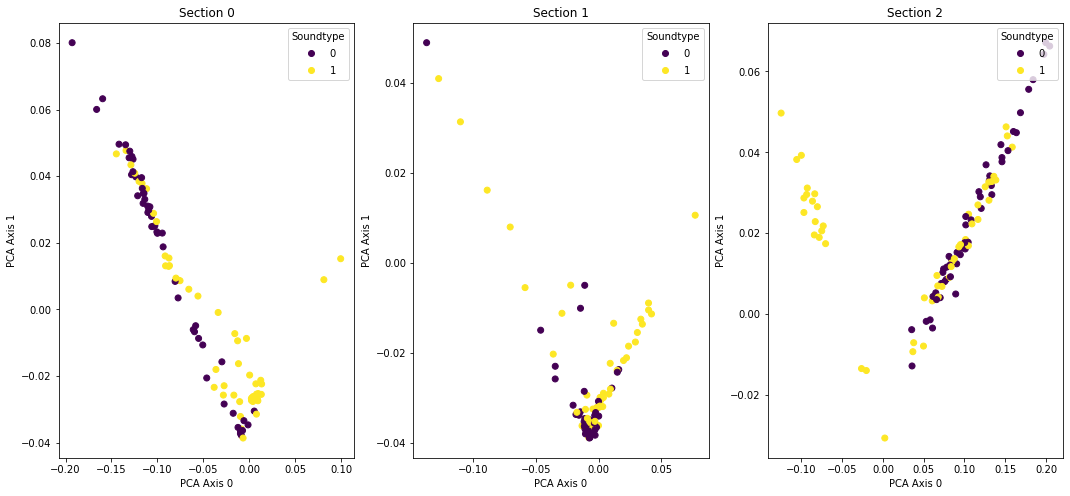

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (18, 8))
for i in range(3):
    ax = axs[i]
    scatter  = ax.scatter(y_pca[y_test_sec==i,0], y_pca[y_test_sec==i,1], c = y_test_soundtype[y_test_sec==i])
    ax.legend(*scatter.legend_elements(), loc = "upper right", title = "Soundtype")
    ax.set_xlabel("PCA Axis 0")
    ax.set_ylabel("PCA Axis 1")
    ax.set_title("Section "+str(i))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(300, 2)
Train score =  1.0


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.85      0.85      0.85        20
           2       1.00      0.88      0.93        24

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.88      0.87      0.87        60



Pred,0,1,2
True,,,
0,14,2,0
1,3,17,0
2,2,1,21


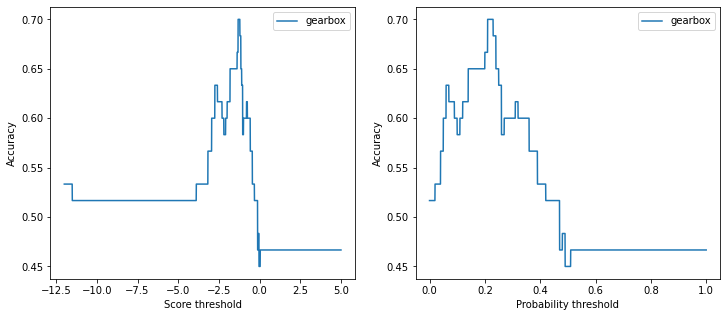

In [ ]:
# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print("Gearbox AUC = ", np.round(auc, 3))


Gearbox AUC =  0.649


Even worse than the previous case when source+target data are taken. But here, we have less data. I should try with all machines and predict the machine or machine + section.

## Repeat with all (source + target) sections but change the loss function (loss to loss2) and the optimizer (SGD to Adam)

#### Start with the gearbox

In [ ]:
# Choose data
machine = 'gearbox'

# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
train_labels = train_df['section']       

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
18000,/content/Features/melspec_313_128/gearbox/sect...,gearbox,2,source,train,0,0918,id_05,4
18004,/content/Features/melspec_313_128/gearbox/sect...,gearbox,0,source,train,0,0825,volt_2.0,4


In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0825, 0950, 0983, 0764, 0088, 0399, 0259, 071...","[volt_2.0, volt_2.0, volt_2.0, volt_1.5, volt_...",4
1,1,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0162, 0064, 0716, 0342, 0392, 0498, 0272, 000...","[wt_50, wt_200, wt_100, wt_150, wt_200, wt_50,...",4
2,2,[/content/Features/melspec_313_128/gearbox/sec...,gearbox,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0918, 0045, 0388, 0926, 0805, 0206, 0947, 096...","[id_05, id_08, id_08, id_05, id_05, id_05, id_...",4


In [ ]:
X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:17<00:00,  5.80s/it]


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

In [ ]:
#alpha = 0.1  # margin parameter for the loss function 'loss'

model.compile(loss=loss_2, optimizer='adam')

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 8s 81ms/step - loss: 0.1382 - val_loss: 0.3746 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 7s 89ms/step - loss: 0.0614 - val_loss: 0.4823 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 6s 79ms/step - loss: 0.0317 - val_loss: 0.3752 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 6s 74ms/step - loss: 0.0278 - val_loss: 0.3852 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 5s 66ms/step - loss: 0.0220 - val_loss: 0.4714 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - ETA: 0s - loss: 0.0230
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
75/75 [==============================] - 5s 65ms/step - loss: 0.0230 - val_loss: 0.3904 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 6s 74ms/step - loss: 0.0192 - val_loss: 0.4509 - lr: 3.0000e-04
Epoch 8/50
75/75 [==============================] - 6s 74ms/step - loss:

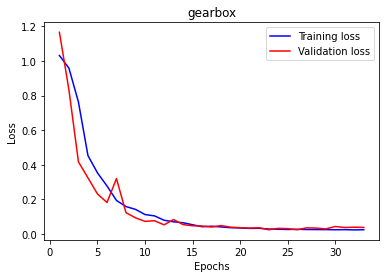

In [ ]:
plot_training_diag(training_history, machine)

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(600, 128)

Make 3D PCA instead of 2D PCA

In [ ]:
#Install plotly because interactive plots with %matplotlib notebook does not work with matplotlib
!pip install plotly

import plotly.express as px


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 3)
y_pca = pca.fit_transform(embedded_test)

dict_pca = {'test_soundtype': y_test_soundtype, 'test_section': y_test_sec, 'pca_ax1': y_pca[:,0], 'pca_ax2': y_pca[:,1], 'pca_ax3': y_pca[:,2]}
df_pca = pd.DataFrame.from_dict(dict_pca)
df_pca['test_section'] = df_pca['test_section'].astype('string')     # to get discrete colors
#df_pca.head()
#fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section', symbol = 'test_soundtype')
fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section')
fig.show()


In [ ]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   test_soundtype  600 non-null    int64  
 1   test_section    600 non-null    string 
 2   pca_ax1         600 non-null    float32
 3   pca_ax2         600 non-null    float32
 4   pca_ax3         600 non-null    float32
dtypes: float32(3), int64(1), string(1)
memory usage: 16.5 KB


In [ ]:

df_pca['test_soundtype'] = df_pca['test_soundtype'].astype('string')     # to get discrete colors


fig = px.scatter_3d(df_pca[df_pca['test_section']=='0'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 0')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='1'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 1')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='2'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 2')
fig.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(600, 2)
Train score =  0.99375


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.76      0.90      0.82        31
           2       0.89      0.83      0.86        48

    accuracy                           0.83       120
   macro avg       0.83      0.84      0.83       120
weighted avg       0.84      0.83      0.83       120



Pred,0,1,2
True,,,
0,32,5,4
1,2,28,1
2,4,4,40


In [ ]:
# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

<IPython.core.display.Javascript object>

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print(machine + " AUC = ", np.round(auc, 3))

aucs_machine_trainonsec = {}
aucs_machine_trainonsec[machine] = auc


gearbox AUC =  0.673


#### Repeat for the slider

In [ ]:
# Choose data
machine = 'slider'

# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
train_labels = train_df['section']       

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
3603,/content/Features/melspec_313_128/slider/secti...,slider,2,source,train,0,0086,f-n_B,5
3604,/content/Features/melspec_313_128/slider/secti...,slider,1,source,train,0,0832,ac_0.05,5


In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/slider/sect...,slider,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0055, 0558, 0327, 0359, 0841, 0205, 0175, 092...","[vel_300, vel_1100, vel_700, vel_700, vel_1100...",5
1,1,[/content/Features/melspec_313_128/slider/sect...,slider,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0832, 0080, 0606, 0752, 0250, 0332, 0746, 000...","[ac_0.05, ac_0.07, ac_0.11, ac_0.03, ac_0.05, ...",5
2,2,[/content/Features/melspec_313_128/slider/sect...,slider,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0086, 0564, 0753, 0515, 0703, 0898, 0770, 046...","[f-n_B, f-n_A, f-n_B, f-n_A, f-n_B, f-n_A, f-n...",5


In [ ]:
X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

In [ ]:
#alpha = 0.1  # margin parameter for the loss function 'loss'

model.compile(loss=loss_2, optimizer='adam')

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 7s 87ms/step - loss: 0.1114 - val_loss: 0.0488 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0429 - val_loss: 0.0340 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 5s 73ms/step - loss: 0.0305 - val_loss: 0.0408 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 5s 73ms/step - loss: 0.0238 - val_loss: 0.0345 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0217 - val_loss: 0.0319 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0184 - val_loss: 0.0230 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0166 - val_loss: 0.0238 - lr: 0.0010
Epoch 8/50
75/75 [==============================] - 5s 73ms/step - loss: 0.0165 - val_loss: 0.0325 - lr: 0.0010
Epoch 9/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0154 - val_loss: 0.0281 - lr:

In [ ]:
plot_training_diag(training_history, machine)

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []
y_test_path = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    y_test_path.append(test_df.loc[i, 'filepath'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)
y_test_path = np.array(y_test_path)

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(600, 128)

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 3)
y_pca = pca.fit_transform(embedded_test)

dict_pca = {'test_soundtype': y_test_soundtype, 'test_section': y_test_sec, 'pca_ax1': y_pca[:,0], 'pca_ax2': y_pca[:,1], 'pca_ax3': y_pca[:,2]}
df_pca = pd.DataFrame.from_dict(dict_pca)
df_pca['test_section'] = df_pca['test_section'].astype('string')     # to get discrete colors
#df_pca.head()
#fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section', symbol = 'test_soundtype')
fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section')
fig.show()


In [ ]:
df_pca['test_soundtype'] = df_pca['test_soundtype'].astype('string')     # to get discrete colors


fig = px.scatter_3d(df_pca[df_pca['test_section']=='0'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 0')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='1'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 1')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='2'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 2')
fig.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype, y_test_path))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(600, 2)
Train score =  1.0


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
y_test_path = ytest_test[:,2]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        34
           1       0.86      0.80      0.83        46
           2       0.83      0.88      0.85        40

    accuracy                           0.82       120
   macro avg       0.82      0.82      0.82       120
weighted avg       0.83      0.82      0.83       120



Pred,0,1,2
True,,,
0,27,5,2
1,4,37,5
2,4,1,35


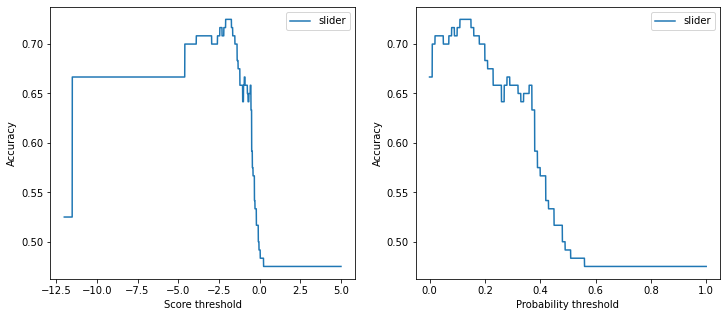

In [ ]:
%matplotlib inline 

# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print(machine + "AUC = ", np.round(auc, 3))

aucs_machine_trainonsec[machine] = auc


sliderAUC =  0.778


Show a few spectrograms with their prediction

In [ ]:
# Not done, we should choose a threshold to get y_pred_soundtype
'''
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
for i in range(2):
    for j in range(2):
        idx = random.randint(0, high=y_test_path.shape[0], size=1)
        spectro_img = load_spectro(y_test_path[idx])

        ax = axs[i,j]
        ax.imshow(spectro_img, cmap = 'magma');
        ax.set_title()
        ax.set_xticks([])
        ax.set_yticks([])
'''

#### Continue with the fan

In [ ]:
# Choose data
machine = 'fan'

# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
train_labels = train_df['section']       

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
21599,/content/Features/melspec_313_128/fan/section_...,fan,2,source,train,0,0415,n-lv_L1,3
21600,/content/Features/melspec_313_128/fan/section_...,fan,1,source,train,0,0308,f-n_A,3


In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/fan/section...,fan,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0106, 0684, 0056, 0294, 0685, 0009, 0697, 011...","[m-n_W, m-n_X, m-n_W, m-n_W, m-n_X, m-n_X, m-n...",3
1,1,[/content/Features/melspec_313_128/fan/section...,fan,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0308, 0650, 0795, 0222, 0131, 0009, 0328, 045...","[f-n_A, f-n_B, f-n_B, f-n_A, f-n_B, f-n_A, f-n...",3
2,2,[/content/Features/melspec_313_128/fan/section...,fan,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0415, 0150, 0070, 0447, 0643, 0758, 0321, 033...","[n-lv_L1, n-lv_L2, n-lv_L1, n-lv_L2, n-lv_L1, ...",3


In [ ]:
X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

In [ ]:
#alpha = 0.1  # margin parameter for the loss function 'loss'

model.compile(loss=loss_2, optimizer='adam')

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 7s 76ms/step - loss: 0.3340 - val_loss: 0.0795 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0862 - val_loss: 0.0508 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0600 - val_loss: 0.0309 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 5s 66ms/step - loss: 0.0403 - val_loss: 0.0284 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0321 - val_loss: 0.0190 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0290 - val_loss: 0.0168 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0283 - val_loss: 0.0141 - lr: 0.0010
Epoch 8/50
75/75 [==============================] - 5s 66ms/step - loss: 0.0289 - val_loss: 0.0158 - lr: 0.0010
Epoch 9/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0250 - val_loss: 0.0166 - lr:

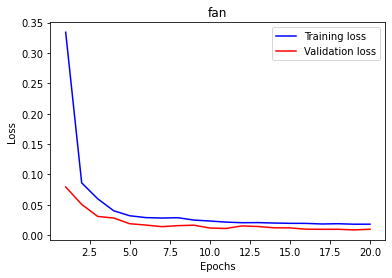

In [ ]:
plot_training_diag(training_history, machine)

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(600, 128)

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 3)
y_pca = pca.fit_transform(embedded_test)

dict_pca = {'test_soundtype': y_test_soundtype, 'test_section': y_test_sec, 'pca_ax1': y_pca[:,0], 'pca_ax2': y_pca[:,1], 'pca_ax3': y_pca[:,2]}
df_pca = pd.DataFrame.from_dict(dict_pca)
df_pca['test_section'] = df_pca['test_section'].astype('string')     # to get discrete colors
#df_pca.head()
#fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section', symbol = 'test_soundtype')
fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section')
fig.show()


In [ ]:
df_pca['test_soundtype'] = df_pca['test_soundtype'].astype('string')     # to get discrete colors


fig = px.scatter_3d(df_pca[df_pca['test_section']=='0'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 0')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='1'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 1')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='2'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 2')
fig.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(600, 2)
Train score =  1.0


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.91      0.94      0.93        33
           2       0.95      0.93      0.94        43

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



Pred,0,1,2
True,,,
0,44,0,0
1,0,31,2
2,0,3,40


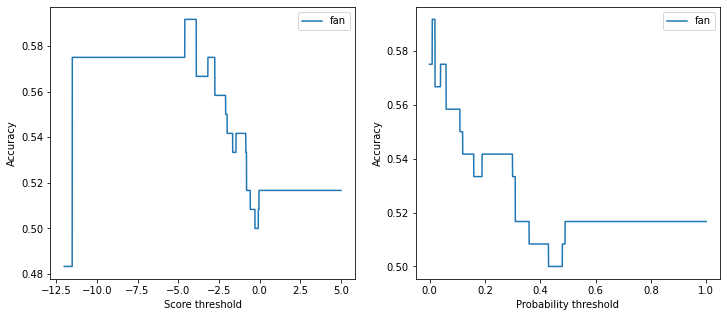

In [ ]:
%matplotlib inline 

# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print(machine + "AUC = ", np.round(auc, 3))

aucs_machine_trainonsec[machine] = auc


fanAUC =  0.565


#### Continue with the bearing

In [ ]:
# Choose data
machine = 'bearing'

# We take only data from the source domain
#train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
#test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
# We take data from the source and target domains
train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
test_df = df[(df['dir']=='test') & (df['machine']==machine)]     

train_filepaths = train_df['filepath']             
train_labels = train_df['section']       

# Separate the train set into train and validation sets
train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                        train_labels, test_size=0.2, \
                                                                        stratify = train_labels)


valid_df = train_df[train_df['filepath'].isin(valid_filepaths)]  # before the next line (redefinition of train_df)
train_df = train_df[train_df['filepath'].isin(train_filepaths)]

train_df.head(2)

,filepath,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
0,/content/Features/melspec_313_128/bearing/sect...,bearing,1,source,train,0,0540,vel_12_loc_B,2
2,/content/Features/melspec_313_128/bearing/sect...,bearing,0,source,train,0,0896,vel_22,2


In [ ]:
data_train = train_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()

data_valid = valid_df.groupby('section').agg({'filepath': list, 'machine': lambda x: x.unique(), \
                                              'domain_env': list, 'dir': lambda x: x.unique(), \
                                              'sound_type': list, 'id': list, 'suffix': list, \
                                              'machine_num': lambda x: x.unique()}).reset_index()


data_train
#print(data_train.loc[0, 'domain_env'].count('target'))
#print(data_train.loc[0, 'domain_env'].count('source'))

,section,filepath,machine,domain_env,dir,sound_type,id,suffix,machine_num
0,0,[/content/Features/melspec_313_128/bearing/sec...,bearing,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0896, 0683, 0183, 0039, 0634, 0416, 0660, 047...","[vel_22, vel_14, vel_22, vel_6, vel_22, vel_18...",2
1,1,[/content/Features/melspec_313_128/bearing/sec...,bearing,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0540, 0850, 0477, 0818, 0911, 0255, 0372, 084...","[vel_12_loc_B, vel_4_loc_A, vel_4_loc_A, vel_1...",2
2,2,[/content/Features/melspec_313_128/bearing/sec...,bearing,"[source, source, source, source, source, sourc...",train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0640, 0203, 0845, 0398, 0689, 0932, 0317, 020...","[vel_6_f-n_B, vel_6_f-n_A, vel_6_f-n_A, vel_6_...",2


In [ ]:
X_train, y_train = load_spectros_per_section(data_train)
X_valid, y_valid = load_spectros_per_section(data_valid)

100%|██████████| 3/3 [00:15<00:00,  5.28s/it]


In [ ]:
batch_size = 32
gen_train = generator(X_train, y_train, epochs=10, batch_size = batch_size, nb_sample = len(train_filepaths))
gen_valid = generator(X_valid, y_valid, epochs=10, batch_size = batch_size, nb_sample = len(valid_filepaths))

In [ ]:
#alpha = 0.1  # margin parameter for the loss function 'loss'

model.compile(loss=loss_2, optimizer='adam')

steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                        factor = 0.3, cooldown = 4, verbose = 1)

training_history = model.fit(gen_train, validation_data = gen_valid, steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps, epochs = 50, callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/50
75/75 [==============================] - 7s 76ms/step - loss: 0.2315 - val_loss: 0.0344 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 6s 74ms/step - loss: 0.0595 - val_loss: 0.0282 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0599 - val_loss: 0.0582 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 5s 73ms/step - loss: 0.0455 - val_loss: 0.0257 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - 5s 66ms/step - loss: 0.0471 - val_loss: 0.0196 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 5s 65ms/step - loss: 0.0395 - val_loss: 0.0197 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0339 - val_loss: 0.0221 - lr: 0.0010
Epoch 8/50
75/75 [==============================] - 5s 72ms/step - loss: 0.0375 - val_loss: 0.0219 - lr: 0.0010
Epoch 9/50
75/75 [==============================] - 5s 73ms/step - loss: 0.0368 - val_loss: 0.0120 - lr:

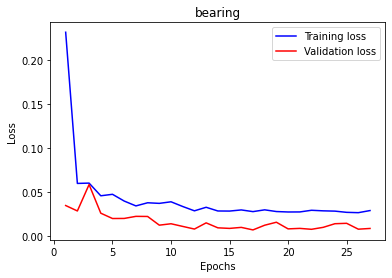

In [ ]:
plot_training_diag(training_history, machine)

In [ ]:
test_df = test_df.reset_index()

X_test = []
y_test_sec = []
y_test_soundtype = []

for i in range(test_df.shape[0]):
    path = test_df.loc[i, 'filepath']
    spectro_array = load_spectro(path)
    X_test.append(spectro_array)
    y_test_sec.append(test_df.loc[i, 'section'])
    y_test_soundtype.append(test_df.loc[i, 'sound_type'])
    
X_test = np.array(X_test)
y_test_sec = np.array(y_test_sec)
y_test_soundtype = np.array(y_test_soundtype)

NameError: ignored

In [ ]:
embedded_test = model.predict(X_test)
embedded_test.shape

(600, 128)

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA(n_components = 3)
y_pca = pca.fit_transform(embedded_test)

dict_pca = {'test_soundtype': y_test_soundtype, 'test_section': y_test_sec, 'pca_ax1': y_pca[:,0], 'pca_ax2': y_pca[:,1], 'pca_ax3': y_pca[:,2]}
df_pca = pd.DataFrame.from_dict(dict_pca)
df_pca['test_section'] = df_pca['test_section'].astype('string')     # to get discrete colors
#df_pca.head()
#fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section', symbol = 'test_soundtype')
fig = px.scatter_3d(df_pca, x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', color = 'test_section')
fig.show()


In [ ]:
df_pca['test_soundtype'] = df_pca['test_soundtype'].astype('string')     # to get discrete colors


fig = px.scatter_3d(df_pca[df_pca['test_section']=='0'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 0')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='1'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 1')
fig.show()

fig = px.scatter_3d(df_pca[df_pca['test_section']=='2'], x = 'pca_ax1', y = 'pca_ax2', z = 'pca_ax3', \
                    color = 'test_soundtype', title = 'Section 2')
fig.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

y_test_both = np.column_stack((y_test_sec, y_test_soundtype))
print(y_test_both.shape)
Xtest_train, Xtest_test, ytest_train, ytest_test = train_test_split(embedded_test, y_test_both, train_size=0.8, random_state=1234)

rfc = RandomForestClassifier()
rfc.fit(Xtest_train, ytest_train[:,0])
print("Train score = ", rfc.score(Xtest_train, ytest_train[:,0]))

pred_section_proba = rfc.predict_proba(Xtest_test)

(600, 2)
Train score =  1.0


In [ ]:
y_pred_section = np.argmax(pred_section_proba, axis=1) 

y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]

In [ ]:
print("*** MACHINE = ", machine + " ***")
print(classification_report(y_true_section, y_pred_section))
display(pd.crosstab(y_true_section, y_pred_section, rownames = ['True'], colnames = ['Pred']))


*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.91      0.94      0.93        33
           2       0.95      0.93      0.94        43

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



Pred,0,1,2
True,,,
0,44,0,0
1,0,31,2
2,0,3,40


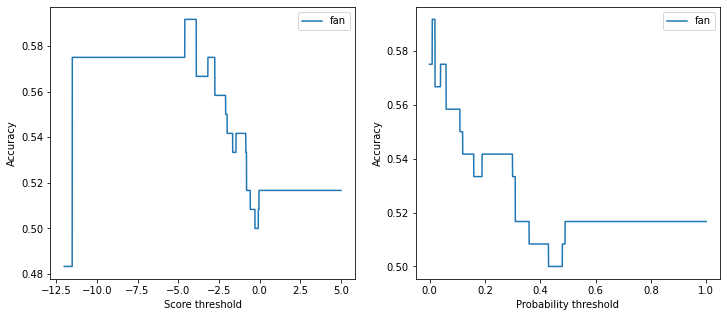

In [ ]:
%matplotlib inline 

# Reciprocal function of the sigmoid function
# To spread input x (between 0 and 1) from ~ -11.5 to 13.8
def inv_sigmoid(x):      # x is a proba between 0 and 1
    if 0.00001<x and x<0.999999:
        y = np.log(x/(1-x))
    elif x<=0.00001:
            y = np.log(0.00001/(1-0.00001))
    else:
            y = np.log(0.999999/(1-0.999999))
    return y





y_pred_section = np.argmax(pred_section_proba, axis=1) 
y_true_section = ytest_test[:,0]
y_true_soundtype = ytest_test[:,1]
pred_section_probamax = np.max(pred_section_proba, axis=1) 
anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
y_pred_soundtype_proba = 1 - pred_section_probamax

# Use a threshold on the anomaly score
accuracies_1 = []
score_thresholds = np.linspace(-12, 5, 2000)
for threshold in score_thresholds:
    y_pred_soundtype = np.where(anomaly_scores > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_1.append(accuracy)

# Use a threshold on the prediction proba
accuracies_2 = []
proba_thresholds = np.linspace(0, 1, 2000)
for threshold in proba_thresholds:
    y_pred_soundtype = np.where(y_pred_soundtype_proba > threshold, 1, 0)
    accuracy = accuracy_score(y_true_soundtype, y_pred_soundtype)
    accuracies_2.append(accuracy)

# Plot soundtype accuracies vs threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.plot(score_thresholds, accuracies_1, label = machine)
ax2.plot(proba_thresholds, accuracies_2, label = machine)

ax1.legend()
ax1.set_xlabel("Score threshold")
ax1.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xlabel("Probability threshold")
ax2.set_ylabel("Accuracy");

In [ ]:
auc = roc_auc_score(y_true_soundtype, y_pred_soundtype_proba)
print(machine + "AUC = ", np.round(auc, 3))

aucs_machine_trainonsec[machine] = auc


fanAUC =  0.565
